In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from GetDataset_2 import *
from Segment import *
from Model import *


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [2]:
train_val_data = Preprocess.read('train_id.txt')
test_data = Preprocess.read('val_id.txt')

train_data, val_data = train_test_split(train_val_data, test_size=0.2)

100%|██████████| 707/707 [00:15<00:00, 45.98it/s]


In [3]:
train_dataset = Preprocess(train_data)
train_dataset_ex1 = Preprocess(train_data, 'train_ex1')
val_dataset = Preprocess(val_data)
test_dataset = Preprocess(test_data)

In [4]:
batch_size = 16
train_dataloader = DataLoader(train_dataset+train_dataset_ex1, batch_size=batch_size, num_workers=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [5]:
model = Model()
loss = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3) #2e-5
Segment = Segmentation(model, loss, optimizer, device='cuda')

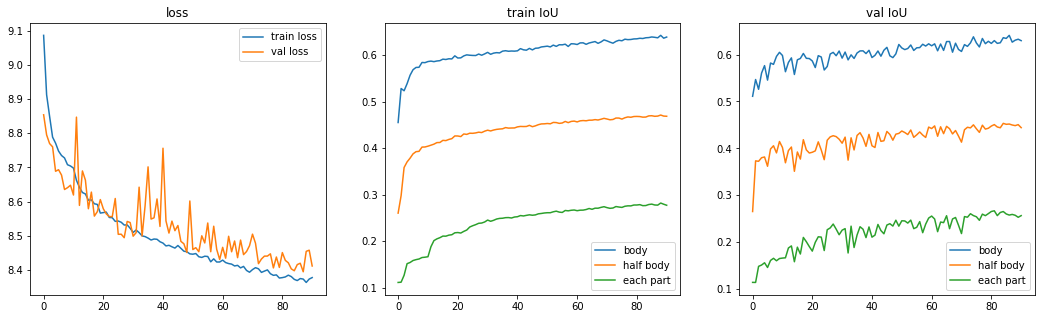

100%|██████████| 100/100 [51:11<00:00, 30.72s/it]
/home/jovyan/arr/other/Segment.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for ind, i in enumerate(np.array(history).T):


In [6]:
history = Segment.fit(train_dataloader, val_dataloader)

#### Метрика на тесте

In [46]:
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=1)

model = Model().to('cuda')
model.load_state_dict(torch.load('./save_model/model_lr4_epochs_80'))
outs, iou = [], []

for x_batch, y_batch in tqdm(test_dataloader):
    x_batch = x_batch.to('cuda')
    y_batch = y_batch.to('cuda')
    
    out0, out1, out2 = Segmentation.predict(model, x_batch.squeeze())
    y_batch_body, y_batch_half = Segmentation.split(y_batch)
    
    avg_iou0 = Segmentation.metric(out0, y_batch_body.squeeze(0), 2)
    avg_iou1 = Segmentation.metric(out1, y_batch_half.squeeze(0), 3)
    avg_iou2 = Segmentation.metric(out2, y_batch.squeeze(0), 7)
    
    iou.append([avg_iou0.cpu(), avg_iou1.cpu(), avg_iou2.cpu()])
    
iou_test = np.mean(iou, axis=0)
print('\tIoU body', 'IoU half body', 'IoU each part\n', *iou_test, sep='\t')

100%|██████████| 707/707 [00:13<00:00, 52.66it/s]

	IoU body	IoU half body	IoU each part
	0.5625926	0.40161183	0.21725556


In [50]:
i = 0
model = Model()
model.load_state_dict(torch.load('./save_model/model_lr4_epochs_90'))
out0, out1, out2 = Segment.predict(model, train_dataset[i][0])
# evaluation(model.to('cuda'), val_dataloader)

In [51]:
out2.shape

torch.Size([1, 7, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


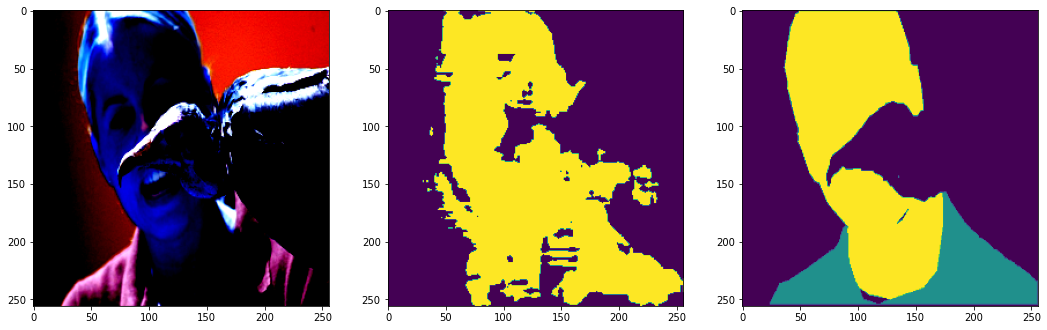

In [52]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
# plt.axis("image")
plt.imshow(train_dataset[i][0].permute(1, 2, 0).detach().numpy())

plt.subplot(1, 3, 2)
# plt.axis("pred mask")
plt.imshow(out0.argmax(dim=1).permute(1, 2, 0).detach().numpy())

plt.subplot(1, 3, 3)
# plt.axis("mask")
plt.imshow(train_dataset[i][1].permute(1, 2, 0).detach().numpy())
plt.show()

Результаты получитель относительные неплохие только для тела. Для более мелких частей нужна более глубокая модель, стоит добавить регуляризаторов, а также увеличить кол-во эпох

### Идеи по улучшению

Из-за ограниченных вычислительных ресурсов в данной работе был реализован стандартный подход на основании Unet
1) Самое очевидное это использование более глубоких или новых нейросетей, например, большие resnet и архитектуры с использование ViT и диффузионных моделей. Так как это уже реализовано для семантической сегментации, то можно подумать над реализацией более сложной архитектуры с добавлением иерархичности.

2) Изменение лосс фунции. Так в статье [Deep Hierarchical Semantic Segmentation](https://openaccess.thecvf.com/content/CVPR2022/papers/Li_Deep_Hierarchical_Semantic_Segmentation_CVPR_2022_paper.pdf) предлагается новая лосс-функция для обучения модели, которая предсказывает не отдельные классы, а сразу все вместе. Потенциально это может облегчить модель и повысить качество

3) Использование текстовых подсказок класса из предобученных моделей на задаче Text2Image. [Harnessing Diffusion Models for Visual Perception with Meta Prompts](https://arxiv.org/pdf/2312.14733v1) 

4) Использовать пофрагментно видео для лучшего понимания движения и лучшей сегментации модели, особено полезно при сегментации движущихся объектов, например, в задаче автодрайвинга. Использование предобученных моделей на задачу depth estimation на основе struct to motion или стерео парах